In [1]:
import yfinance as yf
import os.path 
import pandas as pd

cwd = os.getcwd()
data = os.path.join(cwd, '../data', 'BTC-USD.csv')
data = pd.read_csv(data)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


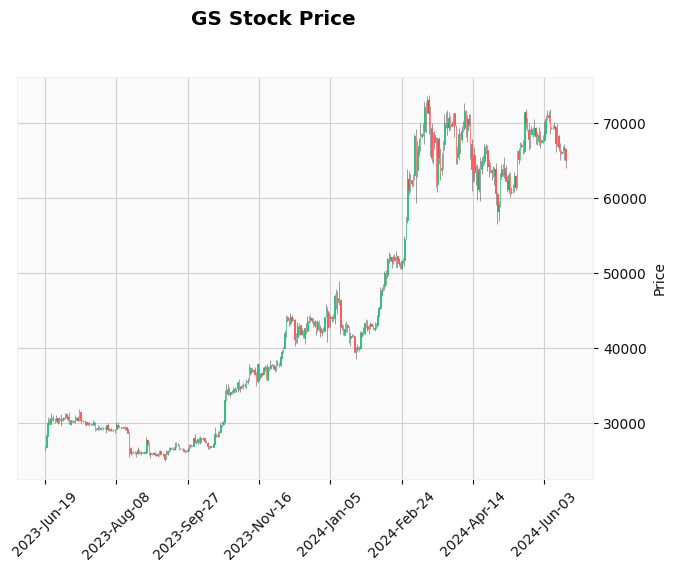

In [2]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# Plot candlestick chart
mpf.plot(data, type="candle", style="yahoo", title="GS Stock Price")

In [3]:
import pandas as pd
import numpy as np

class MovingAverageCrossoverStrategy:
    def __init__(self, short_window, long_window, rsi_window, rsi_type):
        self.short_window = short_window
        self.long_window = long_window
        self.rsi_window = rsi_window
        self.rsi_type = rsi_type

    def calculate_rsi(self, data):
        close_delta = data["Close"].diff()
        up = close_delta.clip(lower=0)
        down = -1 * close_delta.clip(upper=0)

        if self.rsi_type == "simple":
            ma_up = up.rolling(window=self.rsi_window).mean()
            ma_down = down.rolling(window=self.rsi_window).mean()
        elif self.rsi_type == "exponential":
            ma_up = up.ewm(span=self.rsi_window).mean()
            ma_down = down.ewm(span=self.rsi_window).mean()
        else:
            raise ValueError("Invalid RSI type")

        rs = ma_up / ma_down
        rsi = 100 - (100 / (1 + rs))

        return rsi

    def generate_signals(self, data):
        # Calculate moving averages
        data["short_ma"] = data["Close"].rolling(self.short_window).mean()
        data["long_ma"] = data["Close"].rolling(self.long_window).mean()

        # Calculate RSI
        data["rsi"] = self.calculate_rsi(data)

        # Calculate EMA200
        data["ema200"] = data["Close"].ewm(span=200).mean()

        # Generate signals
        data["signal"] = 0
        data.loc[(data["short_ma"] > data["long_ma"]) & (data["Close"] > data["ema200"]) & (data["rsi"] < 30), "signal"] = 1
        data.loc[(data["short_ma"] < data["long_ma"]) | (data["rsi"] > 70), "signal"] = -1

        return data.reset_index()

In [4]:
import plotly.graph_objects as go

# Initialize the strategy
advanced_strategy = MovingAverageCrossoverStrategy(short_window=50, long_window=100, rsi_window=14, rsi_type='simple')

# Generate signals using the strategy
data = advanced_strategy.generate_signals(data)

# Extract buy and sell signals
buy_signals = data[(data["signal"].diff() == 1) | (data["signal"].diff() == -1)].reset_index()
sell_signals = data[(data["signal"].diff() == -2) | (data["signal"].diff() == 1)].reset_index()

# Create candlestick trace
candlestick_trace = go.Candlestick(x=data["Date"], open=data["Open"], high=data["High"],
                                   low=data["Low"], close=data["Close"])

# Create buy and sell signal traces
buy_signal_trace = go.Scatter(x=buy_signals["Date"], y=buy_signals["Close"], mode="markers",
                              marker=dict(symbol="triangle-up", color="green", size=10),
                              name="Buy Signal")
sell_signal_trace = go.Scatter(x=sell_signals["Date"], y=sell_signals["Close"], mode="markers",
                               marker=dict(symbol="triangle-down", color="red", size=10),
                               name="Sell Signal")

# Create figure and add traces
fig = go.Figure(data=[candlestick_trace, buy_signal_trace, sell_signal_trace])

# Update layout
fig.update_layout(title="Advanced Trading Strategy Signals",
                  xaxis_rangeslider_visible=False)

# Save the figure as an image
fig.show()

In [7]:
class PositionSizing:
    def __init__(self, atr_window, risk_per_trade):
        self.atr_window = atr_window
        self.risk_per_trade = risk_per_trade

    def calculate_position_size(self, data):
        # Calculate average true range (ATR)
        data["high_low"] = data["High"] - data["Low"]
        data["high_close"] = abs(data["High"] - data["Close"].shift())
        data["low_close"] = abs(data["Low"] - data["Close"].shift())
        data["true_range"] = data[["high_low", "high_close", "low_close"]].max(axis=1)
        data["atr"] = data["true_range"].rolling(self.atr_window).mean()

        # Calculate position size
        data["position_size"] = (self.risk_per_trade / data["atr"]).fillna(0)

        return data

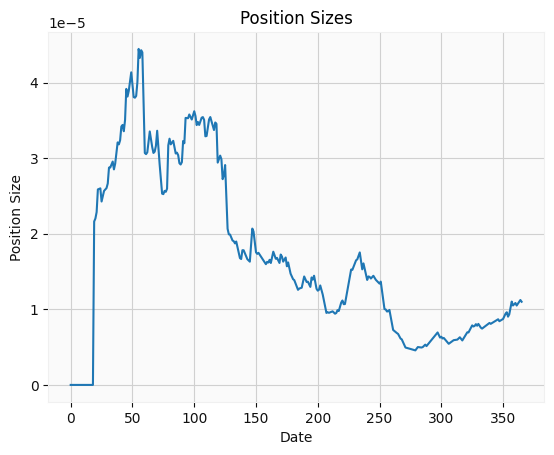

In [8]:
# Initialize the position sizing algorithm
position_sizing = PositionSizing(atr_window=20, risk_per_trade=0.02)

# Calculate position sizes
data = position_sizing.calculate_position_size(data)

# Plot position sizes
plt.plot(data.index, data["position_size"])
plt.title("Position Sizes")
plt.xlabel("Date")
plt.ylabel("Position Size")
plt.grid(True)

In [9]:
import pandas as pd
import numpy as np

class PerformanceEvaluator:
    def calculate_returns(self, data):
        data["returns"] = data["Close"].pct_change()
        data["cumulative_returns"] = (1 + data["returns"]).cumprod()
        return data

    def calculate_performance_metrics(self, data):
        returns = data["returns"]
        cumulative_returns = data["cumulative_returns"]

        if len(cumulative_returns) < 2:
            raise ValueError("Insufficient data to calculate performance metrics")

        total_return = cumulative_returns.iloc[-1] - 1
        annualized_return = (1 + total_return) ** (252 / len(data)) - 1
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)

        return total_return, annualized_return, max_drawdown, sharpe_ratio



In [10]:
# Initialize the performance evaluator
performance_evaluator = PerformanceEvaluator()

# Example usage:
# Calculate returns and performance metrics
data = performance_evaluator.calculate_returns(data)
try:
    total_return, annualized_return, max_drawdown, sharpe_ratio = performance_evaluator.calculate_performance_metrics(data)

    # Print performance metrics
    print("Total Return: {:.2%}".format(total_return))
    print("Annualized Return: {:.2%}".format(annualized_return))
    print("Max Drawdown: {:.2%}".format(max_drawdown))
    print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

except ValueError as ve:
    print(f"Error calculating performance metrics: {ve}")


Total Return: 142.60%
Annualized Return: 84.08%
Max Drawdown: -20.29%
Sharpe Ratio: 1.75
